# **Data scraping of Spotify / Genius artists**

## Imports 

In [48]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm as tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import time
from collections import deque
from openai import OpenAI
import ast

load_dotenv()

SPOTIFY_API_KEY = os.getenv("SPOTIFY_API_KEY_3")
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID_3")
GENIUS_TOKEN = os.getenv("GENIUS_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

TOP_100_PLAYLIST_ID = "0sDahzOkMWOmLXfTMf2N4N"
TIKTOK_PLAYLIST_ID = "57EG9lWmdn7HHofXuQVsow"

auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_API_KEY)
sp = spotipy.Spotify(auth_manager=auth_manager)
llm = OpenAI(api_key=OPENAI_API_KEY)

## Creating sets for top 100 artist and TikTok's songs 

In [49]:
results_top_100 = sp.playlist_items(TOP_100_PLAYLIST_ID)
print("Total number of tracks:", len(results_top_100["items"]))
artist_names = []
for item in results_top_100["items"]:
    track = item["track"]
    artist_names.append(track['artists'][0]['name'])

unique_artist_names_top_100 = set(artist_names)
print("Unique artists in top 100 playlist:", len(unique_artist_names_top_100))

results_tiktok = sp.playlist_items(TIKTOK_PLAYLIST_ID)
print("\nTotal number of tracks in TikTok playlist:", len(results_tiktok["items"]))
artist_names = []
for item in results_tiktok["items"]:
    track = item["track"]
    artist_names.append(track['artists'][0]['name'])
unique_artist_names_tiktok = set(artist_names)
print(f"Unique artists in TikTok playlist: {len(unique_artist_names_tiktok)}\n")

Total number of tracks: 98
Unique artists in top 100 playlist: 44

Total number of tracks in TikTok playlist: 100
Unique artists in TikTok playlist: 85



## Helper functions

In [50]:
def load_checkpoint(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

def save_checkpoint(filename, graph, frontier, node_attributes, artist_ids, current_depth):
    with open(filename, 'wb') as f:
        pickle.dump({
            'graph': graph,
            'frontier': frontier,
            'node_attributes': node_attributes,
            'artist_ids': artist_ids,
            'current_depth': current_depth
        }, f)

In [51]:
class RateLimiter:
    def __init__(self, max_requests=50, window_seconds=30):
        self.max_requests = max_requests
        self.window_seconds = window_seconds
        self.requests = deque()
    
    def wait_if_needed(self):
        now = time.time()
        
        # remove requests older than the window
        while self.requests and self.requests[0] < now - self.window_seconds:
            self.requests.popleft()
        
        # wait until oldest request expires
        if len(self.requests) >= self.max_requests:
            sleep_time = self.window_seconds - (now - self.requests[0]) + 0.5
            if sleep_time > 0:
                print(f"Rate limit reached. Waiting {sleep_time:.1f}s...")
                time.sleep(sleep_time)
                now = time.time()
                while self.requests and self.requests[0] < now - self.window_seconds:
                    self.requests.popleft()
        
        self.requests.append(now)
    
    def get_current_rate(self):
        now = time.time()
        # remove old requests
        while self.requests and self.requests[0] < now - self.window_seconds:
            self.requests.popleft()
        return len(self.requests)

 ### Getting featured artists
We must have `include_groups = 'ablum,single'` to avoid getting artist's "appears on" albums - which are not really collaborations (featuring).


In [52]:
def get_featured_artists(artist_id, sp_client, rate_limiter, max_albums=20, 
                        include_groups='album,single', max_tracks_per_album=None):
    """
    Return aligned lists of featured artist names and ids, deduplicated by id.
    """
    pairs_by_id = {}
    
    rate_limiter.wait_if_needed()
    albums_page = sp_client.artist_albums(artist_id, include_groups=include_groups, limit=max_albums)
    album_items = albums_page.get("items", [])[:max_albums]
    album_ids = [a["id"] for a in album_items if a.get("id")]
    
    if not album_ids:
        return [], []
    
    rate_limiter.wait_if_needed()
    albums_resp = sp_client.albums(album_ids)
    
    for album in (albums_resp.get("albums") or []):
        tracks_block = (album.get("tracks") or {})
        tracks = tracks_block.get("items", [])
        
        if max_tracks_per_album is not None:
            tracks = tracks[:max_tracks_per_album]
        
        for tr in tracks:
            for a in tr.get("artists", []):
                aid = a.get("id")
                if aid and aid != artist_id:
                    pairs_by_id[aid] = a.get("name", aid)
    
    feature_artist_ids = list(pairs_by_id.keys())
    feature_artists = [pairs_by_id[_id] for _id in feature_artist_ids]
    return feature_artists, feature_artist_ids

### Lyrics extractor
This is a function built to extract lyrics from the "Genius" website. Inputs are the song title and artist names both as string, and the output is the lyrics as a string.


In [53]:
def get_lyrics(song_title, artist_name):
    base_url = "https://api.genius.com/search"
    headers = {"Authorization": f"Bearer {GENIUS_TOKEN}"}
    params = {"q": f"{song_title} {artist_name}"}
    response = requests.get(base_url, headers=headers, params=params).json()

    hits = response["response"]["hits"]
    if not hits:
        return None

    for hit in hits:
        result = hit["result"]
        if result["primary_artist"]["name"].lower() == artist_name.lower():
            song_url = result["url"]
            break
    else:
        song_url = hits[0]["result"]["url"]

    page = requests.get(song_url)
    soup = BeautifulSoup(page.text, "html.parser")

    lyrics_divs = soup.select("div[data-lyrics-container='true']")
    if lyrics_divs:
        lyrics = "\n".join(div.get_text(separator="\n") for div in lyrics_divs)
    else:
        candidates = soup.find_all("div", class_=re.compile("(Lyrics__Root|Lyrics-sc-|SongPage__Section)"))
        lyrics = "\n".join(c.get_text(separator="\n") for c in candidates) if candidates else ""

    match = re.search(r"\[verse\s*1\]", lyrics, flags=re.IGNORECASE)
    if match:
        lyrics = lyrics[match.start():]
    
    lyrics = re.sub(r"\[.*?\]", "", lyrics)
    lyrics = re.split(r"You might also like|Embed|See.*Lyrics$", lyrics)[0].strip()

    return lyrics if lyrics else None

## Feature scraper

Combines all the code above to create a dictionary representing the graph and a second containing the node's attributes.

In [70]:
def feature_scraper( 
    graph,
    node_attributes,
    artist_ids,
    unique_artist_names_top_100,
    unique_artist_names_tiktok,
    frontier=None,
    max_depth=2,
    checkpoint_file='data_checkpoint.pkl',
    current_depth=0,
    max_albums_per_artist=20,
    include_groups='album,single',
    fetch_lyrics=False,
    max_tracks_per_album=None,
    max_requests_per_30s=50
):
    # Size of frontier per iteration 0: 44 -> 1: 781/2 -> 2: 12146
    # This limits the rate of requests to Spotify API for the rolling window
    rate_limiter = RateLimiter(max_requests=max_requests_per_30s, window_seconds=30)
    
    # Load checkpoint if starting fresh
    if frontier is None:
        checkpoint = load_checkpoint(checkpoint_file)
        if checkpoint:
            print(f"Resuming from checkpoint {checkpoint_file}")
            graph = checkpoint['graph']
            frontier = checkpoint['frontier']
            node_attributes = checkpoint['node_attributes']
            artist_ids = checkpoint['artist_ids']
            current_depth = checkpoint['current_depth']
        else:
            frontier = []

    # Determine artists to process
    if len(frontier) == 0:
        artists_to_process = list(graph.keys())
        print(f"Starting depth {current_depth}: Processing {len(artists_to_process)} seed artists")
    else:
        # Filter out already processed artists from frontier
        artists_to_process = [
            a for a in set(frontier) 
            if a not in graph or not graph.get(a) or a not in node_attributes or not node_attributes.get(a)
        ]
        print(f"Depth {current_depth}: Processing {len(artists_to_process)} unprocessed artists (from {len(set(frontier))} total frontier)")

    new_frontier = []
    processed_count = 0

    for artist_name in tqdm.tqdm(artists_to_process, desc=f"Depth {current_depth}"):
        
        max_retries = 5
        retry_count = 0
        while retry_count < max_retries:
            try:
                # Display current rate
                current_rate = rate_limiter.get_current_rate()
                print(f"Current rate: {current_rate}/{max_requests_per_30s} req/30s", end='', flush=True)

                artist_id = node_attributes.get(artist_name, {}).get('id') or artist_ids.get(artist_name)
                if not artist_id:
                    rate_limiter.wait_if_needed()
                    results = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
                    items = results.get("artists", {}).get("items", [])
                    if not items:
                        print(f"No results found for {artist_name}")
                        graph[artist_name] = []
                        node_attributes.setdefault(artist_name, {})
                        node_attributes[artist_name]['processing_failed'] = True
                        node_attributes[artist_name]['failure_reason'] = 'artist_not_found'
                        break
                    artist = items[0]
                    artist_id = artist["id"]
                else:
                    rate_limiter.wait_if_needed()
                    artist = sp.artist(artist_id)

                # Save ID and attributes
                artist_ids[artist_name] = artist_id
                node_attributes.setdefault(artist_name, {})
                node_attributes[artist_name]['id'] = artist_id
                node_attributes[artist_name]['popularity'] = artist.get('popularity', 0)
                node_attributes[artist_name]['genres'] = artist.get('genres', [])
                node_attributes[artist_name]['in_top_100'] = artist_name in unique_artist_names_top_100
                node_attributes[artist_name]['in_tiktok'] = artist_name in unique_artist_names_tiktok

                # Get featured artists
                featured_artists, featured_artist_ids = get_featured_artists(
                    artist_id, sp, rate_limiter,
                    max_albums=max_albums_per_artist,
                    include_groups=include_groups,
                    max_tracks_per_album=max_tracks_per_album
                )
                graph[artist_name] = featured_artists

                # Update artist IDs
                for fname, fid in zip(featured_artists, featured_artist_ids):
                    if fname and fid:
                        artist_ids.setdefault(fname, fid)

                # Find top tracks for each artist
                rate_limiter.wait_if_needed()
                top_tracks = sp.artist_top_tracks(artist_id, country='US').get('tracks', [])
                tracks_info = []
                
                for track in top_tracks:
                    td = {
                        'name': track['name'],
                        'popularity': track.get('popularity', 0),
                        'lyrics': None
                    }
                    if fetch_lyrics:
                        try:
                            time.sleep(1.0)
                            td['lyrics'] = get_lyrics(track['name'], artist_name)
                        except Exception:
                            td['lyrics'] = None
                    tracks_info.append(td)
                
                node_attributes[artist_name]['top_10_tracks'] = tracks_info

                # New frontier update
                if featured_artists and current_depth < max_depth - 1:
                    new_frontier.extend(featured_artists)

                processed_count += 1

                # Save checkpoint every 5 artists
                if processed_count % 5 == 0:
                    remaining_frontier = artists_to_process[artists_to_process.index(artist_name) + 1:] + new_frontier
                    save_checkpoint(checkpoint_file, graph, remaining_frontier, node_attributes, 
                                  artist_ids, current_depth)
                
                break

            except spotipy.exceptions.SpotifyException as e:
                if getattr(e, "http_status", None) == 429:
                    retry_after_header = None
                    if hasattr(e, 'headers') and e.headers:
                        retry_after_header = e.headers.get('Retry-After')                    
                    # If Retry-After is unreasonable (> 1 hour), use default
                    if retry_after_header:
                        try:
                            retry_after = int(retry_after_header)
                            if retry_after > 3600*6:  # If more than 6 hours
                                print(f"Rate limited with unreasonable Retry-After: {retry_after}s ({retry_after/3600:.1f}h)")
                                retry_after = 3600 # Only 1 hour if unreasonable
                        except (ValueError, TypeError):
                            retry_after = 3600
                    else:
                        retry_after = 3600
                    
                    print(f"Rate limited! Retry-After: {retry_after}s")
                    
                    # Try waiting 1/4 of the time to see if it gets unstuck 
                    wait_time = max(5, retry_after // 4)
                    print(f"Waiting {wait_time}s (1/4 of {retry_after}s) and retrying...")
                    # Save checkpoint with remaining artists to process
                    try:
                        current_index = artists_to_process.index(artist_name)
                        remaining_frontier = artists_to_process[current_index:] + new_frontier
                    except ValueError:
                        remaining_frontier = new_frontier
                    save_checkpoint(checkpoint_file, graph, remaining_frontier, node_attributes,
                                  artist_ids, current_depth)
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"Spotify Error processing {artist_name}: {e}")
                    graph[artist_name] = []
                    node_attributes.setdefault(artist_name, {})
                    node_attributes[artist_name]['processing_failed'] = True
                    node_attributes[artist_name]['failure_reason'] = str(e)
                    retry_count += 1
                    if retry_count < max_retries:
                        continue
                    break

            except (requests.exceptions.ReadTimeout, requests.exceptions.ConnectionError, TimeoutError) as e:
                wait_time = min(30, 2 ** retry_count)
                print(f"Timeout for {artist_name}. Waiting {wait_time}s and retrying...")
                time.sleep(wait_time)
                continue

            except Exception as e:
                print(f"Unexpected error processing {artist_name}: {e}")
                # Save checkpoint with remaining artists
                try:
                    current_index = artists_to_process.index(artist_name)
                    remaining_frontier = artists_to_process[current_index:] + new_frontier
                except ValueError:
                    remaining_frontier = new_frontier
                save_checkpoint(checkpoint_file, graph, remaining_frontier, node_attributes,
                              artist_ids, current_depth)
                graph[artist_name] = []
                node_attributes.setdefault(artist_name, {})
                node_attributes[artist_name]['processing_failed'] = True
                node_attributes[artist_name]['failure_reason'] = f'unexpected_error: {str(e)}'
                break

        if retry_count >= max_retries:
            print(f"Failed to process {artist_name} after {max_retries} artist-specific errors. Skipping.")

    # New frontier with only artists not already in graph
    new_frontier = [a for a in set(new_frontier) if a not in graph]

    save_checkpoint(checkpoint_file, graph, new_frontier, node_attributes, artist_ids, current_depth)
    print(f"\n✅ Depth {current_depth} complete. Graph: {len(graph)}, New frontier: {len(new_frontier)}")

    # Go to next depth
    if new_frontier and current_depth < max_depth - 1:
        return feature_scraper(
            graph, node_attributes, artist_ids,
            unique_artist_names_top_100, unique_artist_names_tiktok,
            frontier=new_frontier,
            max_depth=max_depth,
            checkpoint_file=checkpoint_file,
            current_depth=current_depth + 1,
            max_albums_per_artist=max_albums_per_artist,
            include_groups=include_groups,
            fetch_lyrics=fetch_lyrics,
            max_tracks_per_album=max_tracks_per_album,
            max_requests_per_30s=max_requests_per_30s
        )

    # Save final file
    final_file = 'data_final.pkl'
    save_checkpoint(final_file, graph, [], node_attributes, artist_ids, current_depth)
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
    print(f"Scraping complete! Saved to {final_file}")

    return graph, node_attributes, new_frontier

In [ ]:
artist_ids = {}
for item in results_top_100["items"]:
    track = item["track"]
    if track and track.get("artists"):
        a = track["artists"][0]
        if a.get("name") and a.get("id"):
            artist_ids[a["name"]] = a["id"]

for item in results_tiktok["items"]:
    track = item["track"]
    if track and track.get("artists"):
        a = track["artists"][0]
        if a.get("name") and a.get("id"):
            artist_ids.setdefault(a["name"], a["id"])


graph = {artist_name: [] for artist_name in unique_artist_names_top_100}
node_attributes = {artist_name: {} for artist_name in unique_artist_names_top_100}

api_keys = [
    (os.getenv("SPOTIFY_CLIENT_ID_1"), os.getenv("SPOTIFY_API_KEY_1")),
    (os.getenv("SPOTIFY_CLIENT_ID_2"), os.getenv("SPOTIFY_API_KEY_2")),
    (os.getenv("SPOTIFY_CLIENT_ID_3"), os.getenv("SPOTIFY_API_KEY_3")),
    (os.getenv("SPOTIFY_CLIENT_ID_4"), os.getenv("SPOTIFY_API_KEY_4")),
    (os.getenv("SPOTIFY_CLIENT_ID_5"), os.getenv("SPOTIFY_API_KEY_5"))
]

# graph, node_attributes, frontier = feature_scraper(
#     graph,
#     node_attributes,
#     artist_ids,
#     unique_artist_names_top_100,
#     unique_artist_names_tiktok,
#     max_depth=3,
#     checkpoint_file='data_checkpoint.pkl',
#     max_albums_per_artist=20,
#     include_groups='album,single',
#     fetch_lyrics=False,
#     max_tracks_per_album=None,
#     max_requests_per_30s=100
# )

## Clean data post scraping

In [ ]:
def impute_missing_genres(node_attributes):
    def impute_genres_llm(artist_name):
        prompt = (
            f"Identify 1, 2 or 3 plausible music genres (short labels) for the recording artist '{artist_name}'. "
            f"Use widely known information about releases and collaborations. "
            f"Return ONLY a Python list like ['genre1','genre2']. If uncertain return ['NoGenre']."
        )
        try:
            resp = llm.chat.completions.create(
                model="gpt-4.1-nano",
                messages=[
                    {"role": "system", "content": "Always answer ONLY a valid Python list of 1-3 short genre strings. Do not explain."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.2,
                max_completion_tokens=40
            )
            raw = resp.choices[0].message.content.strip()
            print(f"LLM response for {artist_name}: {raw}")
            genres = ast.literal_eval(raw)
            if not isinstance(genres, list):
                raise ValueError("Response not a list")
            cleaned = []
            for g in genres:
                g_norm = str(g).strip().lower()
                if g_norm:
                    cleaned.append(g_norm)
                if len(cleaned) == 3:
                    break
            if not cleaned:
                print(f"No genres found for {artist_name}, assigning 'NoGenre'")
                cleaned = ["NoGenre"]
            return cleaned
        except Exception as e:
            print(f"LLM failed for {artist_name}: {e}")
            return ["NoGenre"]
    
    # remove empty names from empty_genre_artists
    missing_artists = [
        artist for artist, attrs in node_attributes.items()
        if not attrs.get("genres") and artist.strip()
    ]
    
    for artist in missing_artists:
        if artist in artist_ids:
            genres = sp.artist(artist_ids[artist])
        else:
            # get artist id via search
            search_results = sp.search(q=f"artist:{artist}", type="artist", limit=1)
            if not search_results.get("artists", {}).get("items"):
                node_attributes[artist]['genres'] = impute_genres_llm(artist, spotify_genres)
            else:
                id = search_results.get("artists", {}).get("items", [])[0].get("id")
                genres = sp.artist(id)

        if genres.get('genres'):
            node_attributes[artist]['genres'] = genres.get('genres', [])
        else:
            node_attributes[artist]['genres'] = impute_genres_llm(artist) 
    return node_attributes  

In [57]:
def clean_data(filename): 
    data = load_checkpoint(filename)
    graph = data['graph']
    node_attributes = data['node_attributes']

    # keep only edges with nodes that are in the graph's nodes
    graph_cleaned = {artist: [neighbor for neighbor in neighbors if neighbor in graph.keys()] for artist, neighbors in graph.items()}

    # keep only the top 5 songs per artist and rename to top_5_tracks
    for artist in node_attributes:
        node_attributes[artist]['top_5_tracks'] = node_attributes[artist].pop('top_10_tracks')[:5]

    # impute missing genres
    node_attributes = impute_missing_genres(node_attributes)

    return graph_cleaned, node_attributes

In [58]:
# DO NOT RUN THIS (unless you need to re-clean the data. Load cleaned data below)
# graph_cleaned, node_attributes = clean_data('data_final_lyrics_depth_2.pkl') 
# remove empty names
# node_attributes = {artist: attrs for artist, attrs in node_attributes.items() if artist.strip()}
# if "" in graph_cleaned.keys():
#     graph_cleaned.pop("")
# save_checkpoint('data_final_cleaned_depth_2.pkl', graph_cleaned, None, node_attributes, None, None)
data_cleaned = load_checkpoint('data_final_cleaned_depth_2.pkl')
graph_cleaned = data_cleaned['graph']
node_attributes = data_cleaned['node_attributes']

In [59]:
############ TEST ###########

# find all artists with empty genres
empty_genre_artists = [artist for artist, attrs in node_attributes.items() if not attrs.get("genres") or attrs.get("genres") == ["NoGenre"]]
print(f"Artists with empty genres {len(empty_genre_artists)}, list is: {empty_genre_artists}\n")

# find all artists with no songs with lyrics
no_lyrics_artists = [artist for artist, attrs in node_attributes.items() if all(track.get("lyrics") is None for track in attrs.get("top_5_tracks", []))]
print(f"Artists with no songs with lyrics {len(no_lyrics_artists)}, list is: {no_lyrics_artists}\n")

# find all artists and each song without lyrics
songs_without_lyrics = {}
for artist, attrs in node_attributes.items():
    missing_lyrics_tracks = [track['name'] for track in attrs.get("top_5_tracks", []) if track.get("lyrics") is None]
    if missing_lyrics_tracks:
        songs_without_lyrics[artist] = missing_lyrics_tracks
print("Artists and their songs without lyrics:")
for artist, tracks in songs_without_lyrics.items():
    print(f"{artist}: {tracks}")

print(f"\nTotal artists with at least one missing-lyrics track: {len(songs_without_lyrics)}\n")

## Manually check if all lyrics are good

Artists with empty genres 0, list is: []

Artists with no songs with lyrics 18, list is: ['Kim Hill', 'Telvis Lawler Jr', 'BRYANN', 'Nicole Hurst', 'Childofnines', 'Yfmroady', 'Big36oz', 'Ryan Adams', '2PRETTY', 'Raedio', 'Boniface', 'Bless', 'Style P', 'Drench', 'Ab-Liva', '4PF DT', 'Ashtro Bot', '$andeep']

Artists and their songs without lyrics:
LAWUYI: ['Bernadine’s interlude']
Marcelo Zarvos: ['Helicopter Arrival', 'My New VP']
Diplo: ['Wish - Audiomack Trap Symphony Version']
Chefin: ['ADORO ESSA VIDA $$$']
El Alfa: ['Kriminal - Prod. by Roberto Ferrante']
Obi Blanche: ['Meaty Beats - Assembler Code Remix']
J. Rey Soul: ['MAMACITA - LittGloss Original Mix']
OG Ron C: ['act xi: she ain’t no angel - ChopNotSlop', '3am - CHOPNOTSLOP']
Fernando Garibay: ['Summer Sunshine - Fernando Garibay Remix', 'Rhythm Divine - Fernando G Remix', "My First Night With You - Fernando G's Extended Vox Version"]
Hans Zimmer: ['He\'s a Pirate - From "Pirates of the Caribbean: The Curse Of the Black Pea

## Debugging lyrics issues

Artists with no songs with lyrics is 24.

The list is: `['Kim Hill', 'Telvis Lawler Jr', 'BRYANN', 'Nicole Hurst', 'Childofnines', 'Danny Pino', 'Yfmroady', 'Big36oz', 'Ryan Adams', '2PRETTY', 'Raedio', 'Boniface', 'Bless', 'Style P', 'Julianne Moore', 'Drench', 'F1 The Album', 'Ab-Liva', 'Hadiya Eshe’', '4PF DT', 'Ashtro Bot', '$andeep', 'Nik Dodani', 'Kaitlyn Dever']`

We look at what songs they have first.

In [60]:
artists_no_lyrics = ['Kim Hill', 'Telvis Lawler Jr', 'BRYANN', 'Nicole Hurst', 'Childofnines', 'Danny Pino', 'Yfmroady', 'Big36oz', 'Ryan Adams', '2PRETTY', 'Raedio', 'Boniface', 'Bless', 'Style P', 'Julianne Moore', 'Drench', 'F1 The Album', 'Ab-Liva', 'Hadiya Eshe’', '4PF DT', 'Ashtro Bot', '$andeep', 'Nik Dodani', 'Kaitlyn Dever']

for artist in artists_no_lyrics:
    tracks = node_attributes[artist].get("top_5_tracks", [])
    track_names = [track["name"] for track in tracks]
    print(artist, ":", track_names)

Kim Hill : []
Telvis Lawler Jr : []
BRYANN : []
Nicole Hurst : []
Childofnines : ['sistas', 'Brooklyn', 'anonymous']
Danny Pino : ['Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack']
Yfmroady : ['Montana']
Big36oz : []
Ryan Adams : []
2PRETTY : []
Raedio : ['Get It Girl (from Insecure: Music From The HBO Original Series, Season 5)', 'Seduce & Scheme (RAP SH!T: Soundtrack From The Max Original Series)', 'Velvet (Remix) [feat. Lucky Daye] [from Insecure: Music From The HBO Original Series, Season 4]', 'Satellite Space Age Edition (feat. Louis Cole & Genevieve Artadi) [from Insecure: Music From The HBO Original Series, Season 5]', "What's The Use (from Insecure: Music From The HBO Original Series, Season 5)"]
Boniface : ['Gezani Umntanami (feat. Killa Punch)', 'BAILAR CONTIGO - Boniface Amapiano Remix', 'Undertaker (feat. Killa Punch, Ogeezykeys)', 'Thuma Mina (feat. Ogeezykeys)', 'Imali']
Bless : []
Style P : ['Amien Ugwanugbemian']
Julianne Moore : ['So Big / So 

Artists with NO SONGS WITH LYRICS:
```Python
# all empty lists are because the artists do not have spotify account
Kim Hill : [] # no songs on
Telvis Lawler Jr : []
BRYANN : []
Nicole Hurst : []
Childofnines : ['sistas', 'Brooklyn', 'anonymous'] # No songs on genius
Danny Pino : ['Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists just as "Requiem" Kaitlyn Dever, Danny Pino & Amy Adams
Yfmroady : ['Montana'] # No songs on genius
Big36oz : []
Ryan Adams : []
2PRETTY : []
Raedio : ['Get It Girl (from Insecure: Music From The HBO Original Series, Season 5)', 'Seduce & Scheme (RAP SH!T: Soundtrack From The Max Original Series)', 'Velvet (Remix) [feat. Lucky Daye] [from Insecure: Music From The HBO Original Series, Season 4]', 'Satellite Space Age Edition (feat. Louis Cole & Genevieve Artadi) [from Insecure: Music From The HBO Original Series, Season 5]', "What's The Use (from Insecure: Music From The HBO Original Series, Season 5)"] # Seduce & Scheme exists, What's The Use exists (the rest do not)
Boniface : ['Gezani Umntanami (feat. Killa Punch)', 'BAILAR CONTIGO - Boniface Amapiano Remix', 'Undertaker (feat. Killa Punch, Ogeezykeys)', 'Thuma Mina (feat. Ogeezykeys)', 'Imali'] # No songs on genius
Bless : []
Style P : ['Amien Ugwanugbemian'] # No songs on genius
Julianne Moore : ['So Big / So Small - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists
Drench : []
F1 The Album : ['Just Keep Watching (From F1® The Movie)', 'Lose My Mind (feat. Doja Cat) [From F1® The Movie]', 'Messy (From F1® The Movie)', 'Drive (From F1® The Movie)', 'Bad As I Used To Be (From F1® The Movie)'] # Just keep watching by Tate McRae, Lose My Mind by Don Toliver, Messy by ROSÉ, Bad As I Used To Be by Chris Stapleton
Ab-Liva : []
Hadiya Eshe’ : ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists by Ben Platt, Amandla Stenberg, Liz Kate, DeMarius Copes, Isaac Powell, Hadiya Eshe, Kaitlyn Dever & Dear Evan Hansen Choir
4PF DT : []
Ashtro Bot : []
$andeep : ['$till The Motto', 'All the Blame', '$andeep (Blessings)', 'Swap Out', 'No Love'] # No genius songs
Nik Dodani : ['Sincerely Me - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists by Colton Ryan, Ben Platt & Nik Dodani
Kaitlyn Dever : ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'Only Us - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'If I Could Tell Her - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Only Us bt Kaitlyn Dever & Ben Platt and If I Could Tell Her by Ben Platt & Kaitlyn Dever
```

Artists with only some of their songs with missing lyrics:

```Python
LAWUYI: ['Bernadine’s interlude'] # NO LYRICS DATA
Marcelo Zarvos: ['Helicopter Arrival', 'My New VP'] # No lyrics data on either songs
Don Toliver: ['Lose My Mind (feat. Doja Cat) [From F1® The Movie]'] # Just as "Lose My Mind" by Don Toliver
ROSÉ: ['Messy (From F1® The Movie)'] # Just as "Messy" by ROSÉ
Tate McRae: ['Just Keep Watching (From F1® The Movie)'] # Just as "Just Keep Watching" by Tate McRae
EastSide K-Boy: ["Ain't No Fun (feat. Dj Primetime & Kalan.FrFr)"] # Aint No Fun by Kalan.FrFr
Large Professor: ['I Juswanna Chill'] # As "Ijuswannachill" b Large Professor
Mark Ronson: ['Valerie (feat. Amy Winehouse) - Version Revisited'] # As "Valerie" by Mark Ronson 
Diplo: ['Wish - Audiomack Trap Symphony Version'] # No lyrics
Chefin: ['ADORO ESSA VIDA $$$'] # No lyrics
El Alfa: ['Kriminal - Prod. by Roberto Ferrante'] # No lyrics
Obi Blanche: ['Entertainment (Obi Blanche & Andert Tysma Brokopondo Ambient Remake)', 'Meaty Beats - Assembler Code Remix'] # Entertainment by Thomas Azier and the second one no lyrics
DJ Jazzy Jeff: ['Rock Wit U - Yoruba Soul Mix - Dub'] # Rock Wit U by DJ Jazzy Jeff
J. Rey Soul: ['MAMACITA - LittGloss Original Mix'] # No lyrics
Peewee Longway: ['South Memphis to Zone 6'] # South Memphis to Zone 6 by Young Dolph
OG Ron C: ['act xi: she ain’t no angel - ChopNotSlop', 'Another Night (Chopnotslop Remix)', '3am - CHOPNOTSLOP'] # Another Night (Chopnotslop Remix) by Clara La San and to other songs = no lyrics
Amandla Stenberg: ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'The Anonymous Ones - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists under original title but with many more artists
Fernando Garibay: ['Summer Sunshine - Fernando Garibay Remix', 'Rhythm Divine - Fernando G Remix', "My First Night With You - Fernando G's Extended Vox Version"] # No lyrics
Paul Cauthen: ['Holy Ghost Fire - Electrophunck Remix'] # Holy Ghost Fire by Paul Cauthen
Hans Zimmer: ['He\'s a Pirate - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score'] # No lyrics
JoJo: ['Too Little Too Late - 2018'] # Too Little Too Late by JoJo
Buscabulla: ['Ta Que Tiembla - Pachyman Remix'] # Ta Que Tiembla by Buscabulla
Tina (Hoodcelebrityy): ['Issa Snack - Remix'] # No lyrics
Gianluca Vacchi: ['ENAMORAO - Afro House Version', 'Ya No Quiero Tu Querer - Dark Mix'] # No lyrics
Playboi Carti: ['Popular (with Playboi Carti & Madonna) - From The Idol Vol. 1 (Music from the HBO Original Series)'] # Popular by The Weeknd & Madonna
Childofnines: ['sistas', 'Brooklyn', 'anonymous'] # Not on genius
Oscar Scheller: ['Plastic Doll - Ashnikko Remix'] # Plastic Doll (Ashnikko Remix) by Lady Gaga
Star.One: ['MasterBlaster 2025'] # No lyrics
Ashnikko: ['Paint The Town Blue (from the series Arcane League of Legends)'] #  Paint The Town Blue Ashnikko, Arcane & League of Legends
Danny Pino: ['Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Exists just as "Requiem" Kaitlyn Dever, Danny Pino & Amy Adams
Angel Ureta: ['Propio Mundo'] # No lyrics
Yfmroady: ['Montana'] # No songs on genius
Kid Cudi: ['Pursuit Of Happiness - Extended Steve Aoki Remix'] # Pursuit Of Happiness by Kid Cudi
Alison Mosshart: ['What a Wonderful World - From "Sons of Anarchy"'] # Under original 
Lil Dicky: ['Molly (feat. Brendon Urie of Panic at the Disco)'] # Under original
Pharrell Williams: ['Happy - From "Despicable Me 2"'] # Original title
Alexiane Broque: ['Encore une fois', "J'aime pas les filles", "Mais oui c'est ça"] # No lyrics
Asake: ['Getting Paid \u200b(f\u200beat\u200b. Asake, Wizkid, Skillibeng\u200b)'] # Getting Paid by Sarz
Amy Adams: ['Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Mentioned before
Daecolm: ['I Adore You (with J Balvin & Ellie Goulding)'] # I Adore You by HUGEL, Topic & Arash
Joe Jonas: ['Wouldn\'t Change a Thing - From "Camp Rock 2: The Final Jam"'] # Original tilte by Joe Jonas & Demi Lovato
Twista: ['Overnight Celebrity (feat. Miri Ben-Ari)'] # Original title
Zeph Ellis: ['Karmageddon'] # No lyrics
Devlin: ['(All Along The) Watchtower - Radio Edit'] # (All Along The) Watchtower by Devlin
Wallie the Sensei: ['Scandalous (feat. Mar & Yah-L)'] # Scandalous by Wallie the Sensei
Yogi: ['It Feels Alright - Miguel Migs Petalpusher Rework'] # No lyrics
DeMarius Copes: ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Original title
Jill Scott: ['He Loves Me (Lyzel in E-Flat) (2020 Remastered)'] # He Loves Me (Lyzel in E Flat) by Jill Scott
Gabriela: ['Celestial Synth Mosaic'] # No lyrics
Raedio: ['Get It Girl (from Insecure: Music From The HBO Original Series, Season 5)', 'Seduce & Scheme (RAP SH!T: Soundtrack From The Max Original Series)', 'Velvet (Remix) [feat. Lucky Daye] [from Insecure: Music From The HBO Original Series, Season 4]', 'Satellite Space Age Edition (feat. Louis Cole & Genevieve Artadi) [from Insecure: Music From The HBO Original Series, Season 5]', "What's The Use (from Insecure: Music From The HBO Original Series, Season 5)"] # Mentioned before most under original titles
DJ Fetti Fee: ['Haitian Tea (FAST)'] # No lyrics
Guillaume Beaujolais: ['C\'est la Fête - De "La Belle et la Bête"/Bande Originale Française du Film', 'Jours Enchantés - De "La Belle et la Bête"/Bande Originale Française du Film', 'Je ne savais pas - De "La Belle et la Bête"/Bande Originale Française du Film'] # Jours enchantés by Walt Disney Records and Je ne savais pas by Magali Bonfils, Aloïs Agaësse-Mahieu, Sophie Delmas, Philippe Catoire, Guillaume Beaujolais, Yoni Amar & Emmylou Homs
Boniface: ['Gezani Umntanami (feat. Killa Punch)', 'BAILAR CONTIGO - Boniface Amapiano Remix', 'Undertaker (feat. Killa Punch, Ogeezykeys)', 'Thuma Mina (feat. Ogeezykeys)', 'Imali'] # Not on genius
Xanctum: ['tokyo ghoul', 'd34dsh0t', 'Cadência Funk', 'BAILAR CONTIGO - Phonk Remix by Xanctum'] # No lyrics
Armaan Malik: ['Pehla Pyaar (From "Kabir Singh")', 'Vibe Undi (From "Mirai") [Telugu]'] # Armaan Malik - Pehla Pyaar (Romanized) by Genius Romanizations
Bump J: ['Move Around - New EQ'] # Move Around by Bump J
Noize Trip: ['(Love Is Like A) Heat Wave - Noizetrip Mix'] # (Love Is Like a) Heat Wave by Martha Reeves & The Vandellas
Omah Lay: ['Isaka II (6am) [with Tems, Omah Lay, Thukuthela, JAZZWRLD, Lekaa Beats]'] # Isaka II (6am) by Ciza, Tems & Omah Lay
Babes Wodumo: ['Not Available (feat. Babes Wodumo & Tribby Wadi Bhozza)'] # No lyrics
Rylo Rodriguez: ['F*cked A Fan'] # No lyrics
Re-Up Gang: ['Re-Up Anthem - 2DR Monkee remix'] # Re-Up Anthem by Re-Up Gang
Posdnuos: ['Stay The Course - Instrumental', 'Stay The Course - A Cappella'] # No lyrics
Hitta J3: ['CERTIFIED STEPPAS (feat. EST Gee, Hitta J3)'] # No lyrics
Style P: ['Amien Ugwanugbemian'] # No lyrics
Julianne Moore: ['So Big / So Small - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Mentioned before
Smif-N-Wessun: ['Wreckonize - Remix Vocal'] # Under original name
Juicy J: ['Shell Shocked (feat. Kill the Noise & Madsonik) - From "Teenage Mutant Ninja Turtles"'] # Shell Shocked by Juicy J, Wiz Khalifa & Ty Dolla $ign
Vanco: ['Ma Tnsani (Yalla Habibi) - Tiësto Remix', 'Iza Ngamandla'] # No lyrics
Kenny Loggins: ['Danger Zone - From "Top Gun" Original Soundtrack', 'Meet Me Half Way - From "Over The Top" Soundtrack', 'Playing with the Boys - From "Top Gun" Original Soundtrack'] # Original titles
Bangladesh: ['Somnoler', 'Steve Caballero'] # No lyrics
DJ Candlestick: ['Another Night (Chopnotslop Remix)', 'Too Many Nights (feat. Don Toliver & with Future) - ChoppedNotSlopped'] # These songs are not on genius
Karin Zavala: ['Capítulo 1'] # No lyrics
Zacari: ['Redemption (with Babes Wodumo)'] # No lyrics
Yaviah: ['Ru102 Medley'] # No lyrics
Kd Young Cocky: ['Nervous (feat. G. Herbo)', 'Lifestyle (feat. YFN Lucci)'] # Not on genius
Gary Lightbody: ["Jock O'Hazeldean - From Turn"] # No lyrics
YOVNGCHIMI: ['TU$$I (with Dei V)'] # No lyrics
Dice Soho: ['Ms. Molly (feat. 1Mill, Fiixd & Younggu)'] # No lyrics
Bastien Jacquemart: ['Tous Les Bateaux, Tous Les Oiseaux', 'Emmenez-Moi'] # No lyrics
TWICE: ['TAKEDOWN (JEONGYEON, JIHYO, CHAEYOUNG) (from the Netflix film KPop Demon Hunters)'] # Original title
Dei V: ['Narcotics (with Bryant Myers)'] # No lyrics
AFROJACK: ['Maldito Alcohol (Pitbull vs. Afrojack)'] # Maldito Alcohol Pitbull
Coucheron: ['HeadBand (feat. 2 Chainz) - Coucheron Remix', 'Danseproblem'] # No lyrics
F1 The Album: ['Just Keep Watching (From F1® The Movie)', 'Lose My Mind (feat. Doja Cat) [From F1® The Movie]', 'Messy (From F1® The Movie)', 'Drive (From F1® The Movie)', 'Bad As I Used To Be (From F1® The Movie)'] # Mentioned before
Tito Torbellino Jr: ['El Vago De Los Nike'] # No lyrics
Colton Ryan: ['Sincerely Me - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'A Little Closer - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'Duquesne Whistle / Señor (Tales of Yankee Power) / Is Your Love In Vain? / License to Kill (Reprise)']
Louis The Child: ["It's Strange (feat. K.Flay) - jigitz Remix"] # Under original name
Bite Da Don: ['Bicheal Jordon (1985 the Intro)'] # Under original
Dante Santiago: ['Bakit Kaya (Tagalog Version)'] # 0
Wreckno: ['Moon Sigil (Smoakland Remix)'] # 0 
Diddy: ['I Need a Girl (Pt. Two) [feat. Ginuwine, Loon, Mario Winans & Tammy Ruggieri]'] # Only part 1 exists...
Arijit Singh: ['Dhun (From "Saiyaara")', 'Agar Tum Saath Ho (From "Tamasha")', 'Humdard (From "Ek Villain")', 'Tujhe Kitna Chahne Lage (From "Kabir Singh")'] # No lyrics under this artist
Don Diablo: ['Keeping Your Head Up - Don Diablo Remix; Radio Edit'] # 0 
Potter Payper: ['Gangsteritus Part 2 (feat. Nines & Tiggs Da Author)'] # Gangsteritus Part 2 by Potter Payper
Grupo Codiciado: ['El Peor De Tus Antojos (En Vivo)'] # No lyrics
Keith Harris: ['Bonzai - Lumidelic Remix'] # 0
キヨサク: ['TAHITI'] # No lyrics
Azul Botticher: ['Dorada / Golden - Cover acústico'] # 0 
Doja Cat: ['Lose My Mind (feat. Doja Cat) [From F1® The Movie]'] # Same as before 
Wizkid: ['Getting Paid \u200b(f\u200beat\u200b. Asake, Wizkid, Skillibeng\u200b)'] # 0 
Esthero: ['Superheroes'] # Superheroes by Esthero
Marciano Cantero: ['La Muralla Verde - Versión Sinfónico [En Vivo]', 'Las Luces del Bar (feat. Javier Calamaro)'] # La Muralla Verde aby Los Enanitos Verdes and other is 0
Eyezic: ['Lighthouse - Eyezic Remix', 'Revolving door - Wreckno remix'] # No lyrics
Scar: ['Connected (FSOE754)', 'Un Beso - Remasterizado'] # 0 
Ali Shaheed Muhammad: ['Sunflowers - Instrumental', 'Ethiopian Sunshower'] # 0 
Hadiya Eshe’: ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Mentioned before
Mozzy: ['Last One Standing (feat. Polo G, Mozzy & Eminem) - From Venom: Let There Be Carnage'] # Last One Standing and Skylar Grey, Polo G, Mozzy & Eminem
Skull-E: ['Wolverine (feat. Shad Da God & Skull-E)'] # 0
Colin Munroe: ['Start A War (From "Class of \'09 The Anime Pilot" Soundtrack)'] # 0
Trio Vegabajeño: ['La Copa Rota', 'Medley: Trío Vegabajeño', 'Lo Nuestro Termino', 'Los Tres Reyes Magos'] # Not on genius
$andeep: ['$till The Motto', 'All the Blame', '$andeep (Blessings)', 'Swap Out', 'No Love'] # No genius songs
MoRuf: ["Ogi's Interlude (feat. Ogi)"] # 0
Nik Dodani: ['Sincerely Me - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # Mentioned before
Kaitlyn Dever: ['You Will Be Found - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'Only Us - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'Requiem - From The “Dear Evan Hansen” Original Motion Picture Soundtrack', 'If I Could Tell Her - From The “Dear Evan Hansen” Original Motion Picture Soundtrack'] # MENTIONED BEFORE
DJ Premier: ['AEAO (Sped Up)'] # 0
Bilal: ['Soul Sista - Remix / From "Queen & Slim: The Soundtrack"'] # Soul Sista by Bilal
TisaKorean: ['Gabby (Vino24k Remix)'] # 0
```

## Manual patching of lyrics data

In [61]:
def patch_lyrics(artist, old_title, new_title, new_artist=None):
    tracks = node_attributes[artist]["top_5_tracks"]
    
    for track in tracks:
        if track["name"] == old_title:
            lyrics = get_lyrics(new_title, new_artist or artist)
            track["lyrics"] = lyrics
            return True
    return False

In [62]:
insert_artist = "ROSÉ"

result = patch_lyrics(
    artist=insert_artist,
    old_title='Messy (From F1® The Movie)',
    new_title='Messy',
    new_artist=insert_artist
)

if result:
    print("Patched!")
else:
    print("Track not found")

# Test:
node_attributes[insert_artist]["top_5_tracks"]

Patched!


[{'name': 'APT.',
  'popularity': 83,
  'lyrics': "111 Contributors\nTranslations\nRomanization\nEnglish\nTürkçe\nEspañol\n简体中文 (Simplified Chinese)\nРусский (Russian)\nKiswahili\nDeutsch\nالعربية\nفارسی\nItaliano\nไทย (Thai)\n繁體中文 (Traditional Chinese)\nবাংলা\nFrançais\nעברית (Hebrew)\nPolski\nPortuguês\nBahasa Indonesia\nsrpski\nहिन्दी (Hindi)\nČesky\nAPT. Lyrics\n“APT.” is the first single released by both Bruno Mars and ROSÉ from the latter’s debut album rosie. The song is Bruno’s second collab in 2024, following “Die With A Smile.”\n\nThe song references the Korean… \nRead More\n\xa0\n\n채영이가 좋아하는 랜덤 게임\n랜덤 게임\nGame start\n\n아파트, 아파트\n아파트, 아파트\n아파트, 아파트\nUh, uh-huh, uh-huh\n아파트, 아파트\n아파트, 아파트\n아파트, 아파트\nUh, uh-huh, uh-huh\n\nKissy face, kissy face\nSent to your phone, but\nI'm tryna kiss your lips for real (Uh-huh, uh-huh)\nRed hearts, red hearts\nThat's what I'm on, yeah\nCome give me somethin' I can feel, oh-oh, oh\n\nDon't you want me like I want you, baby?\nDon't you need me li

In [63]:
# save_checkpoint('data_final_cleaned_depth_2_v2.pkl', graph_cleaned, None, node_attributes, None, None)

In [64]:
data_cleaned_test = load_checkpoint('data_final_cleaned_depth_2.pkl')
graph_cleaned_test = data_cleaned_test['graph']
node_attributes_test = data_cleaned_test['node_attributes']

In [65]:
############ TEST ########### 
# LIST is shorter now, the rest is 100% people with no spotify data NOR genius lyrics

# find all artists with empty genres
empty_genre_artists = [artist for artist, attrs in node_attributes_test .items() if not attrs.get("genres") or attrs.get("genres") == ["NoGenre"]]
print(f"Artists with empty genres {len(empty_genre_artists)}, list is: {empty_genre_artists}\n")

# find all artists with no songs with lyrics
no_lyrics_artists = [artist for artist, attrs in node_attributes_test.items() if all(track.get("lyrics") is None for track in attrs.get("top_5_tracks", []))]
print(f"Artists with no songs with lyrics {len(no_lyrics_artists)}, list is: {no_lyrics_artists}\n")

# find all artists and each song without lyrics
songs_without_lyrics = {}
for artist, attrs in node_attributes_test.items():
    missing_lyrics_tracks = [track['name'] for track in attrs.get("top_5_tracks", []) if track.get("lyrics") is None]
    if missing_lyrics_tracks:
        songs_without_lyrics[artist] = missing_lyrics_tracks
print("Artists and their songs without lyrics:")
for artist, tracks in songs_without_lyrics.items():
    print(f"{artist}: {tracks}")

print(f"\nTotal artists with at least one missing-lyrics track: {len(songs_without_lyrics)}\n")


## Manually check if all lyrics are good

Artists with empty genres 0, list is: []

Artists with no songs with lyrics 18, list is: ['Kim Hill', 'Telvis Lawler Jr', 'BRYANN', 'Nicole Hurst', 'Childofnines', 'Yfmroady', 'Big36oz', 'Ryan Adams', '2PRETTY', 'Raedio', 'Boniface', 'Bless', 'Style P', 'Drench', 'Ab-Liva', '4PF DT', 'Ashtro Bot', '$andeep']

Artists and their songs without lyrics:
LAWUYI: ['Bernadine’s interlude']
Marcelo Zarvos: ['Helicopter Arrival', 'My New VP']
Diplo: ['Wish - Audiomack Trap Symphony Version']
Chefin: ['ADORO ESSA VIDA $$$']
El Alfa: ['Kriminal - Prod. by Roberto Ferrante']
Obi Blanche: ['Meaty Beats - Assembler Code Remix']
J. Rey Soul: ['MAMACITA - LittGloss Original Mix']
OG Ron C: ['act xi: she ain’t no angel - ChopNotSlop', '3am - CHOPNOTSLOP']
Fernando Garibay: ['Summer Sunshine - Fernando Garibay Remix', 'Rhythm Divine - Fernando G Remix', "My First Night With You - Fernando G's Extended Vox Version"]
Hans Zimmer: ['He\'s a Pirate - From "Pirates of the Caribbean: The Curse Of the Black Pea

# Plotting

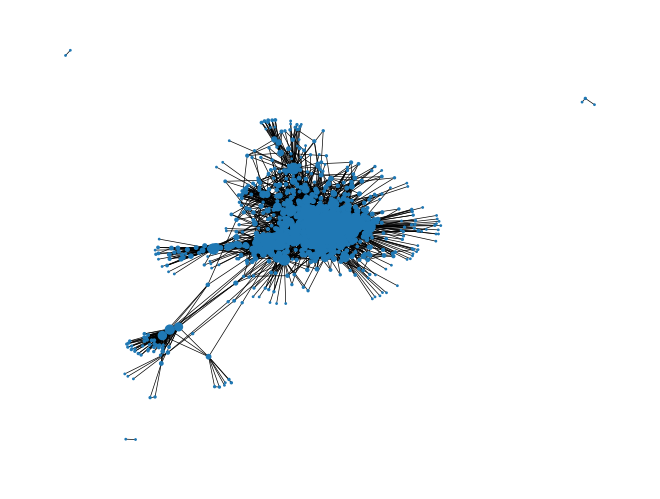

In [66]:
G = nx.Graph(graph_cleaned)
# add the node attributes from your dictionary
nx.set_node_attributes(G, node_attributes)
G_degrees = [G.degree(node) for node in G.nodes()]  
nx.draw(G, with_labels=False, width=0.5, node_size=[d*1 for d in G_degrees])
plt.show()

## Cleaning dataset with depth 3

In [67]:
def clean_data_depth_3(filename): 
    data = load_checkpoint(filename)
    graph = data['graph']
    node_attributes = data['node_attributes']

    # keep only edges with nodes that are in the graph's nodes
    graph_cleaned = {artist: [neighbor for neighbor in neighbors if neighbor in graph.keys()] for artist, neighbors in graph.items()}

    # keep only the top 5 songs per artist and rename to top_5_tracks
    for artist in node_attributes:
        if 'top_10_tracks' in node_attributes[artist]:
            node_attributes[artist]['top_5_tracks'] = node_attributes[artist].pop('top_10_tracks')[:5]
        else:
            node_attributes[artist]['top_5_tracks'] = [None, None, None, None, None]

    data_depth_2 = load_checkpoint('data_final_cleaned_depth_2.pkl')
    node_attributes_d2 = data_depth_2['node_attributes']

    missing_genres = [artist for artist, attrs in node_attributes.items() if not attrs.get("genres") and artist.strip()]
    print(f"Artists with missing genres before using the depth 2 for imputation: {len(missing_genres)}")
    for artist in node_attributes:
        if artist in node_attributes_d2:
            node_attributes[artist]['genres'] = node_attributes_d2[artist]['genres']

    missing_genres = [artist for artist, attrs in node_attributes.items() if not attrs.get("genres") and artist.strip()]
    print(f"Artists with missing genres before imputation: {len(missing_genres)}")

    # impute missing genres
    node_attributes = impute_missing_genres(node_attributes)

    missing_genres = [artist for artist, attrs in node_attributes.items() if not attrs.get("genres") and artist.strip()]
    print(f"Artists with missing genres after imputation: {len(missing_genres)}")

    return graph_cleaned, node_attributes

In [73]:
# DO NOT RUN THIS (unless you need to re-clean the data. Load cleaned data below)
# graph_cleaned, node_attributes = clean_data_depth_3('data_final_depth_3.pkl') 
# # remove empty names
# node_attributes = {artist: attrs for artist, attrs in node_attributes.items() if artist.strip()}
# if "" in graph_cleaned.keys():
#     graph_cleaned.pop("")
# save_checkpoint('data_final_cleaned_depth_3.pkl', graph_cleaned, None, node_attributes, None, None)
data_cleaned = load_checkpoint('data_final_cleaned_depth_3.pkl')
graph_cleaned = data_cleaned['graph']
node_attributes = data_cleaned['node_attributes']

In [75]:
############ TEST ########### 
# find all artists with empty genres
empty_genre_artists = [artist for artist, attrs in node_attributes .items() if not attrs.get("genres") or attrs.get("genres") == ["NoGenre"]]
print(f"Artists with empty genres {len(empty_genre_artists)}, list is: {empty_genre_artists}\n")

Artists with empty genres 0, list is: []

